In [46]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [47]:
import numpy as np
import pandas as pd

In [48]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [50]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [51]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [52]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [54]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [55]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Climate Analysis

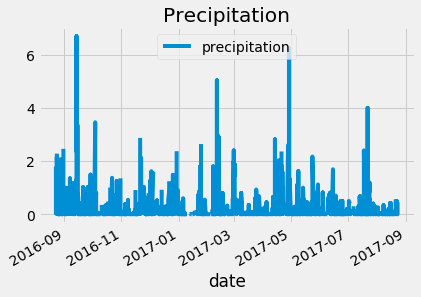

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = session.query(Measurement.date).order_by(Measurement.date.desc())

# Calculate the date 1 year ago from the last data point in the database
last = query.first()
last = str(last[0])
y_ago = dt.datetime.strptime(last, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > y_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(data, columns=['date', 'precipitation'])
prec_df['date'] = pd.to_datetime(prec_df['date'], format='%Y-%m-%d')
prec_df.set_index('date', inplace=True)

# Sort the dataframe by date
prec_df = prec_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
#plt.rcParams['figure.figsize'] = [15, 10]

prec_df.plot(title="Precipitation")
plt.xlabel('date')
plt.legend(loc='upper center')

plt.savefig("Images/Precipitation.png")
plt.show()

In [60]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [61]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Stations: {available_stations} ")

Stations: 9 


In [62]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [63]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active=active[0][0]
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
temps

[(54.0, 85.0, 71.66378066378067)]

In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temps= session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps= most_temps[0]
most_temps

'USC00519281'

In [65]:
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= y_ago).filter(Measurement.station == most_temps).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['tobs'])
temperature_observations.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


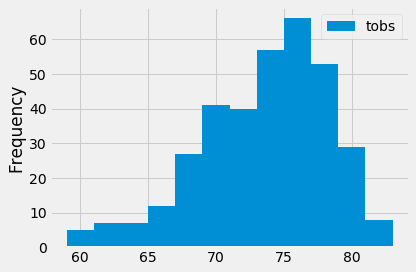

In [85]:
temperature_observations.plot.hist(bins=12)
plt.tight_layout()
plt.savefig("Images/tobs.png")
plt.show()


In [67]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-01-01','2017-01-14')
trip

[(60.0, 68.47619047619048, 81.0)]

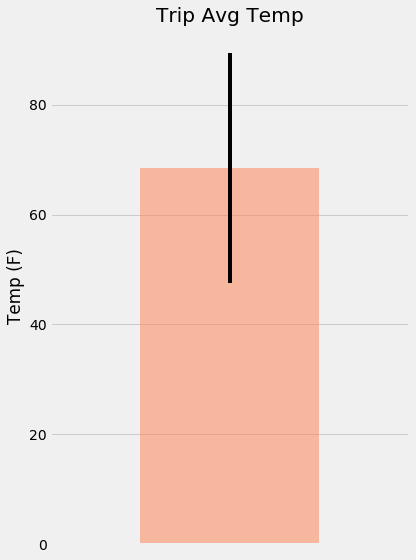

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])
trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), 
                 title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(6,8))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [70]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    list = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    return session.query(*list).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-01-01','2017-01-14'))


[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.03), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.03), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None)]


## Optional Challenge Assignment

In [71]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [77]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-01-01'
end_date ='2017-01-14'
# Use the start and end date to create a range of dates
range = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        group_by(Measurement.date).all()
# Stip off the year and save a list of %m-%d strings
list = [x[0] for x in range]
strip = [x[5:] for x in list]
start_month_day = strip[0]
end_month_day = strip[-1]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter\
           (func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date)\
            <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]
normals = normals[0]
print("Aggregate Daily Normals for 01-01 to 01-14")
normals

Aggregate Daily Normals for 01-01 to 01-14


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0)]

In [82]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
normals_df['date'] = list

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
normals_df['date'] = pd.to_datetime(normals_df['date'], format='%Y-%m-%d')

# Set index to date
normals_df = normals_df.set_index('date')

normals_df

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0


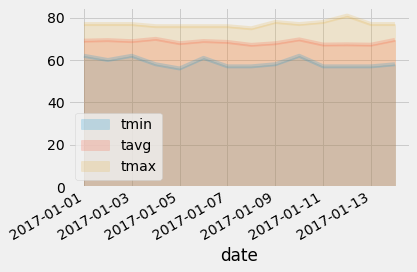

In [83]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True,)
plt.tight_layout()
plt.savefig("Images/DailyNorms.png")
plt.show()